# Support Vector Machine

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
import sys
from pathlib import Path

# Setup paths to access shared common code (utils)
current_dir = Path.cwd()
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import utils

RANDOM_STATE = 42

In [20]:
# Load the CUP training data
ids, X, y = utils.load_cup_data(train=True)

# Split: 90% Development, 10% Internal Test
# Using the same random_state as the team to ensure consistent splits

X_dev, X_test_internal, y_dev, y_test_internal = utils.split_data(X, y, random_state=RANDOM_STATE)

print(f"Total samples: {len(X)}")
print(f"Development Set shape: {X_dev.shape} (Used for Model Selection)")
print(f"Internal Test Set shape: {X_test_internal.shape} (Used ONLY for final check)")

Total samples: 500
Development Set shape: (450, 12) (Used for Model Selection)
Internal Test Set shape: (50, 12) (Used ONLY for final check)


In [21]:
# Define Hyperparameters to study for the SVM grid search
c_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 0.2]
gamma_values = ['scale', 0.1, 0.01]

# --------- 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

print("Starting SVM Grid Search...")

for c in c_values:
    for eps in epsilon_values:
        for gamma in gamma_values:
            fold_mees = []
            
            for train_index, val_index in kf.split(X_dev):
                # 1. SPLIT DATA
                X_fold_train, y_fold_train = X_dev.iloc[train_index], y_dev.iloc[train_index]
                X_fold_val, y_fold_val = X_dev.iloc[val_index], y_dev.iloc[val_index]
                
                # 2. Normalization - Crucial for SVM convergence
                scaler = utils.CupScaler()
                X_train_scaled, y_train_scaled = scaler.fit_transform(X_fold_train, y_fold_train)
                X_val_scaled, y_val_scaled = scaler.transform(X_fold_val, y_fold_val)
                
                # 3. TRAIN SVM (SVR) MODEL
                svm_base = SVR(kernel='rbf', C=c, epsilon=eps, gamma=gamma)
                regr = MultiOutputRegressor(svm_base)
                regr.fit(X_train_scaled, y_train_scaled)
                
                # 4. PREDICT & INVERSE TRANSFORM
                y_pred_scaled = regr.predict(X_val_scaled)
                y_pred_original = scaler.inverse_transform_y(y_pred_scaled)
                
                # 5. Compute MEE in Original Space
                fold_mee = utils.mean_euclidean_error(y_true=y_fold_val, y_pred=y_pred_original)
                fold_mees.append(fold_mee)
            
            avg_mee = np.mean(fold_mees)
            results.append({'C': c, 'eps': eps, 'gamma': gamma, 'mee': avg_mee})

print("Grid Search Complete.")

Starting SVM Grid Search...
Grid Search Complete.


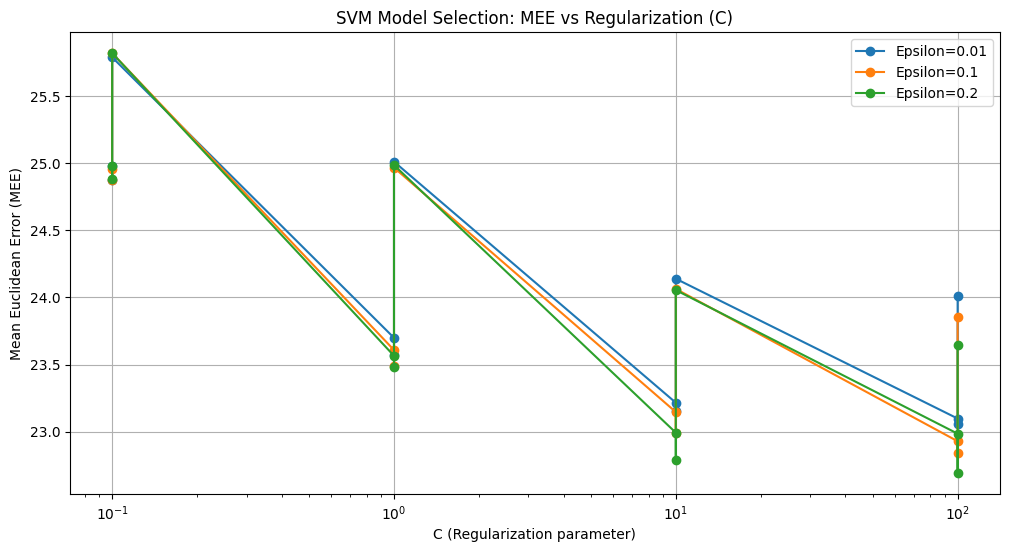

BEST CONFIGURATION: C=100.0, Eps=0.2, Gamma=0.1
Best Validation MEE: 22.6918


In [17]:
# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot MEE vs C for different epsilon values
plt.figure(figsize=(12, 6))
for eps in epsilon_values:
    subset = results_df[results_df['eps'] == eps]
    plt.plot(subset['C'], subset['mee'], marker='o', label=f'Epsilon={eps}')

plt.xscale('log') 
plt.title('SVM Model Selection: MEE vs Regularization (C)')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Mean Euclidean Error (MEE)')
plt.legend()
plt.grid(True)
plt.show()

# Identify the Best Hyperparameters
best_row = results_df.loc[results_df['mee'].idxmin()]
best_c, best_eps, best_gamma = best_row['C'], best_row['eps'], best_row['gamma']
print(f"BEST CONFIGURATION: C={best_c}, Eps={best_eps}, Gamma={best_gamma}")
print(f"Best Validation MEE: {best_row['mee']:.4f}")

In [22]:
# 1. RETRAIN ON FULL DEVELOPMENT SET
final_scaler = utils.CupScaler()
X_dev_scaled, y_dev_scaled = final_scaler.fit_transform(X_dev, y_dev)

final_svm = MultiOutputRegressor(SVR(kernel='rbf', C=best_c, epsilon=best_eps, gamma=best_gamma))
final_svm.fit(X_dev_scaled, y_dev_scaled)

# 2. EVALUATE ON INTERNAL TEST SET
X_test_scaled, _ = final_scaler.transform(X_test_internal)
y_test_pred_original = final_scaler.inverse_transform_y(final_svm.predict(X_test_scaled))

test_mee = utils.mean_euclidean_error(y_true=y_test_internal, y_pred=y_test_pred_original)

# 3. FINAL REPORT
print("-" * 30)
print(f"FINAL REPORT (SVM)")
print("-" * 30)
print(f"Validation MEE (CV): {best_row['mee']:.4f}")
print(f"Internal Test MEE:   {test_mee:.4f}")
print("-" * 30)  

------------------------------
FINAL REPORT (SVM)
------------------------------
Validation MEE (CV): 22.6918
Internal Test MEE:   23.4194
------------------------------
